# Carga del dataset a la notebook

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd 
import descartes
import contextily as ctx
import osmnx as ox
from shapely.geometry import Point

In [ ]:
data = pd.read_csv('properatti.csv')

# Limpieza del dataset y primer análisis de datos faltantes

###Dropeo inicial de columnas

In [ ]:
data.columns

**Columnas que no aportan información a nivel individual de datos:**

Algunas columnas poseen información que no aportan al análisis de datos. Por ejemplo, la columna "Unnamed 0:" es un duplicado de los índices, y la columna "operation" toma el valor "sell" para todas las filas, y "country_name" siempre tiene el valor "Argentina":

In [ ]:
data['operation'].value_counts()

La columna "expenses" tiene demasiados datos faltantes, y esa información no puede ser recuperada de otros campos.

In [ ]:
print('Porcentaje de nulos en columna expensas:', 
      round((data['expenses'].isnull().sum())/len(data['expenses'])*100,2),'%')

Eliminamos entonces las columnas que no aportan información relevante:

In [ ]:
data.drop(columns=['Unnamed: 0', 
                   'operation',
                   'place_with_parent_names',
                   'country_name',
                   'geonames_id',
                   'lat-lon',
                   'currency',
                   'expenses',
                   'properati_url',
                   'image_thumbnail'],
          inplace = True)

In [ ]:
data.head(3)

### Elección de datos de precio

Como las propiedades sin precio no sirven para generar o probar ningún modelo, y es un dato que no podemos recuperar desde otra columna del DataFrame, tenemos que eliminarlas sí o sí. Hay 3 columnas con datos de precios totales, y 2 con datos de precio por metro cuadrado. En el caso de las 3 primeras, observamos que hay una cantidad igual de datos nulos (no puede extraerse info en ninguna moneda), y hay aún más datos faltantes cuando hablamos de precio por superficie:

In [ ]:
print('Cantidad de nulos en columna "price": ', data['price'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_usd": ', data['price_aprox_usd'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_local_currency": ', data['price_aprox_local_currency'].isnull().sum())
print('Cantidad de nulos en columna "price_usd_per_m2": ', data['price_usd_per_m2'].isnull().sum())
print('Cantidad de nulos en columna "price_per_m2": ', data['price_per_m2'].isnull().sum())

Por una cuestión de mercado en Argentina, creemos conveniente tomar como precio válido el precio de las propiedades en dólares. Habiendo intentado sin éxito completar nulos a través de datos en la columna "description", y sabiendo (por lo que describimos arriba) que no podemos obtener esos datos en otras monedas, optamos por eliminar todas las filas que no contienen datos en "price_aprox_usd", y chequeamos que esto elimina todos los datos nulos relacionados a precios totales:

In [ ]:
print('Tamaño antes de limpieza del dataset: ', len(data), '\n')
data = data.dropna(axis = 0, subset = ['price_aprox_usd'])
print('Tamaño luego de limpieza del dataset: ', len(data))

In [ ]:
print('Cantidad de nulos en columna "price": ', data['price'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_usd": ', data['price_aprox_usd'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_local_currency": ', data['price_aprox_local_currency'].isnull().sum())

### Eliminación de datos duplicados

In [ ]:
data.drop_duplicates(inplace = True)
print('Tamaño del dataset luego de eliminar las filas duplicadas: ', len(data))

### Recuperación de datos

Observamos que los datos de "surface_covered_in_m2" contienen valores que, según las descripciones, son claramente erróneos. Por ejemplo, vemos que hay muchas propiedades con una superficie cubierta inferior a 21 m2 y en todos los casos analizados pudimos determinar que se trataba de un error. También quitamos todos los valores de superficies cubiertas menores a 25 m2 en propiedades con mas de un ambiente ya que también consideramos que es un error. Por otra parte, encontramos que las propiedades de tipo "home", "PH" y "apartment" que tenían una superficie cubierta superior a los 1000 m2 también podían ser consideradas como errores de carga de datos si leemos la descripción de la publicación.

Por este motivo, antes de comenzar a extraer datos, llenamos con nulos todos los valores mencionados en el punto anterior. De esta forma, pretendemos volver a completarlo luego con un valor correcto o, en su defecto, eliminar esta fila posteriormente.

In [ ]:
print('Cantidad de nulos en surface_covered_in_m2 antes:', 
      data['surface_covered_in_m2'].isnull().sum())

data['surface_covered_in_m2'] = data.apply(
    lambda x: np.NaN if (x['surface_covered_in_m2'] < 21) else x['surface_covered_in_m2'], axis = 1)

data['surface_covered_in_m2'] = data.apply(
    lambda x: np.NaN if ((x['surface_covered_in_m2'] > 1000) & (x['property_type'] != 'store')) else x['surface_covered_in_m2'], axis = 1)

def f_nulos(x):
    if ((x['surface_covered_in_m2'] < 25) & (x['rooms'] > 1)):
        return np.NaN
    else:
        return x['surface_covered_in_m2']

data['surface_covered_in_m2'] = data.apply(f_nulos, axis = 1)

print('Cantidad de nulos en surface_covered_in_m2 después:', 
      data['surface_covered_in_m2'].isnull().sum())


In [ ]:
# El campo "description" no puede contener nulos para poder extraer los datos.

data['description'] = data['description'].fillna('Sin descripcion')

Creamos una función para intentar recuperar valores de "surface_covered_in_m2" a partir de la descripción del inmueble:

In [ ]:
def minar_sup_cubierta(dataset):
    """Intenta extraer el valor de la superficie cubierta desde la columna dataset['description']"""   
    print('Extrayendo datos...')
    
    dataset['cub_m2'] = dataset['surface_covered_in_m2'].astype(float).copy()
    
    antes = dataset['cub_m2'].isnull().sum()
    print('Nulos antes:', antes)
   
    patrones = ['departamento de ((\S+)m)', 'departamento de ((\S+) m)', 'departamento de((\S+)m)', 
                'departamento de((\S+) m)', 'departamento ((\S+)m)', 'departamento ((\S+) m)', 
                'casa de ((\S+)m)', 'casa de ((\S+) m)', 'casa de((\S+)m)', 'casa de((\S+) m)', 'casa ((\S+)m)', 
                'casa ((\S+) m)', 'depto. de ((\S+)m)', 'depto. de ((\S+) m)', 'depto de ((\S+)m)', 
                'depto de ((\S+) m)', 'depto ((\S+)m)', 'depto ((\S+)m)', 'depto. ((\S+)m)', 'depto. ((\S+) m)', 
                'semipiso de ((\S+) m)', 'semipiso de ((\S+)m)', 'semipiso ((\S+) m)', 'semipiso ((\S+)m)',
                'local ((\S+)m)', 'local ((\S+) m)', 'local de ((\S+)m)', 'local de ((\S+) m)', 'comercial de ((\S+)m)', 
                'comercial de ((\S+) m)',
                
                'cubierta de ((\S+) m)', 'cubierta de ((\S+)m)', 'cubierta ((\S+) m)', 'cubierta ((\S+)m)', 
                'cubierta es de ((\S+)m)', 'cubierta es de ((\S+) m)', 'cubierta de((\S+)m)', 'cubierta de((\S+) m)',
                'cubierta : ((\S+)m)', 'cubierta : ((\S+) m)', 'cubierta: ((\S+) m)', 'cubierta: ((\S+)m)',
                'sup.cub: ((\S+) m)', 'sup.cub: ((\S+)m)', 'sup.cub:((\S+) m)', 'sup.cub:((\S+)m)', 'cub: ((\S+) m)', 
                'cub: ((\S+ )m)', 'cub.: ((\S+) m)', 'cub.: ((\S+ )m)', '((\S+) m2 cub)', '((\S+)m2 cub)', 
                '((\S+) metros cub)',  'cubiertos: ((\S+)m)', 'cubiertos: ((\S+) m)',                
                '((\S+) metros const)', '((\S+)m2 const)', '((\S+) m2 const)', 'construidos: ((\S+)m)', 'construidos: ((\S+) m)', 
                'amplio de ((\S+) m)', 'amplio de ((\S+)m)',  '( (\S+) m2 exclus)']
   
    pat2 = '[a-zA-Z:-]+'
    rg = re.compile(pat2, flags = re.IGNORECASE)

    def f_cub(x):
        if (x['cub_m2'] > 0):
            return x['cub_m2']
        elif regex.search(x['description']) != None:
            s = regex.search(x['description']).group(2)
            try:
                n = float(s)
                if n < 21:
                   return np.NaN
                else:
                   return float(n)
            except:
                n = rg.sub('',s)
                try:
                    if n < 21:
                      return np.NaN
                    else:
                      return float(n)
                except:
                    return np.NaN
        else:
            return np.NaN
        
    for i, patron in enumerate(patrones):
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cub_m2'] = dataset.apply(f_cub, axis = 1)
        
    serie = dataset['cub_m2'].copy()
    
   
    despues = serie.isnull().sum() 
    print('Nulos despues:', despues, '\n')
    
    print('Fin del proceso. Se encontraron', (antes - despues), 'nuevos datos')
    
    return serie


In [ ]:
serie_sup_cub = minar_sup_cubierta(data.loc[:, ['surface_covered_in_m2', 'description']])

In [ ]:
data['surface_covered_in_m2'] = serie_sup_cub.copy()
del serie_sup_cub

Recuperamos todos los valores posibles de "rooms":

In [ ]:
def minar_ambientes(dataset):
    """Intenta extraer el número de ambientes desde la columna dataset['description']"""
    
    dataset['ambientes'] = dataset['rooms'].astype(float).copy()   #pd.Series([np.NaN for i in range(len(dataset))])
    
    num_to_text = ['cero', 'un', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 
                   'nueve', 'diez']
    
    j = 0
    
    for i in range(1, 10):
        patron = '(' + str(i) + ' amb)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text[i] + ' amb)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else i, axis = 1)
        
        print('Cant. Nulos con iteración: ', i, ' ', dataset['ambientes'].isnull().sum())
        j = i
        
    j+=1    
    patron = '(monoamb)'
    regex = re.compile(patron, flags = re.IGNORECASE)
    dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else 1, axis = 1)
    print('Cant. Nulos con interación: ', j, ' ', dataset['ambientes'].isnull().sum())
    j+=1
    
    patron = '(mono amb)'
    regex = re.compile(patron, flags = re.IGNORECASE)
    dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else 1, axis = 1)
    print('Cant. Nulos con interación: ', j, ' ', dataset['ambientes'].isnull().sum())
    j+=1
    
    patron = '(ambiente unico)'
    regex = re.compile(patron, flags = re.IGNORECASE)
    dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else 1, axis = 1)

    patron = '(ambiente único)'
    regex = re.compile(patron, flags = re.IGNORECASE)
    dataset['ambientes'] = dataset.apply(lambda x: x['ambientes'] if regex.search(x['description']) == None else 1, axis = 1)

    
    print('\nCant. final de nulos: ', dataset['ambientes'].isnull().sum())
    
    #retorna una serie
    return dataset['ambientes']
    

In [ ]:
print('Cantidad inicial de nulos en "rooms":', data['rooms'].isnull().sum(), '\n')
serie_ambientes = minar_ambientes(data.loc[:,['rooms', 'description']])

In [ ]:
data['rooms'] = serie_ambientes.copy()
del serie_ambientes

Ahora intentamos extraer la cantidad de habitaciones de cada propiedad:



In [ ]:
def minar_habitaciones(dataset):
    """Intenta extraer el número de habitaciones desde la columna dataset['description']"""
    
    dataset['cuartos'] = pd.Series([np.NaN for i in range(len(dataset))])
    
    print('Cant. inicial de nulos:', len(dataset))
   
    num_to_text = ['cero', 'una', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']
    num_to_text2 = ['cero', 'un', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve']
    num_to_text3 = ['cero', 'primer', 'segundo', 'tercer', 'cuarto', 'quinto', 'sexto', 'septimo', 
                    'octavo', 'noveno']
    num_to_text4 = ['cero', 'primera', 'segunda', 'tercera', 'cuarta', 'quinta', 'sexta', 'septima', 
                    'octava', 'novena']


    # Empiezo por la mayor cantidad de habitaciones ya que a veces se describen como
    # "5 habitaciones, 2 hab. en pb y 3 hab. en pa."

    for i in range(9, 0, -1):     
        
        patron = '(' + str(i) + ' hab)'
        regex = re.compile(patron, flags = re.IGNORECASE)    
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text[i] + ' hab)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
                     
        patron = '(' + str(i) + ' dorm)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text2[i] + ' dorm)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
        
        patron = '(' + str(i) + ' cuarto)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text2[i] + ' cuarto)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                              x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text3[i] + ' dorm)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                            x['description']) == None else i, axis = 1)
        
        patron = '(' + num_to_text4[i] + ' hab)'
        regex = re.compile(patron, flags = re.IGNORECASE)
        dataset['cuartos'] = dataset.apply(lambda x: x['cuartos'] if regex.search(
                            x['description']) == None else i, axis = 1)
        
        
        print('Cant. Nulos con iteración: ', i, ' ', dataset['cuartos'].isnull().sum())
        
    #retorna una serie
    return dataset['cuartos']


In [ ]:
serie_cuartos = minar_habitaciones(data.loc[:,['description']])

Buscando la definición de "ambientes", encontramos que pueden aproximarse como la cantidad de habitaciones + 1. Entonces utilizamos los datos de cantidad de habitaciones extraídos en el punto anterior para estimar la cantidad de ambientes de las viviendas para las cuales no tenemos este dato.
Fuente: https://planosycasas.net/tres-ambientes-cuantos-dormitorios-son/

In [ ]:
data['cuartos'] = serie_cuartos

data['rooms'] = data.apply(lambda x: (x['cuartos'] + 1) if pd.isna(x['rooms'])
                                      else x['rooms'], axis = 1)
                
print('Cantidad final de nulos en "rooms":', data['rooms'].isnull().sum())


In [ ]:
prop_nul_apart = data[data['property_type'] == 'apartment']['rooms'].isnull().sum() / len(data[data['property_type'] == 'apartment']['rooms'])
print("Proporcion de nulos (ambientes) para departamentos: ", prop_nul_apart.round(2))
prop_nul_house = data[data['property_type'] == 'house']['rooms'].isnull().sum() / len(data[data['property_type'] == 'house']['rooms'])
print("Proporcion de nulos (ambientes) para casas: ", prop_nul_house.round(2))
prop_nul_PH = data[data['property_type'] == 'PH']['rooms'].isnull().sum() / len(data[data['property_type'] == 'PH']['rooms'])
print("Proporcion de nulos (ambientes) para PHs: ", prop_nul_PH.round(2))


In [ ]:
data_post_extraccion = data.copy()  #respaldo de datos para no perder tiempo

### Determinación de nuestra columna target

De la cantidad de nulos que vimos antes, sabemos que hay filas que, aunque tienen dato en precio total, no cuentan con información de precio por superficie. Volvemos a corroborar estos datos para el nuevo DataFrame:

In [ ]:
print('Cantidad de nulos en columna "price": ', data['price'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_usd": ', data['price_aprox_usd'].isnull().sum())
print('Cantidad de nulos en columna "price_aprox_local_currency": ', data['price_aprox_local_currency'].isnull().sum())
print('Cantidad de nulos en columna "price_usd_per_m2": ', data['price_usd_per_m2'].isnull().sum())
print('Cantidad de nulos en columna "price_per_m2": ', data['price_per_m2'].isnull().sum())

Como el target para nuestro modelo es el precio por metro cuadrado, necesitamos ese dato o al menos información para deducirlo. Por lo tanto, si no contamos con precio por superficie, o con la superficie del inmueble para calcularlo con el precio, debemos eliminar la fila.

In [ ]:
data_pricesup = data.dropna(subset = ['price_usd_per_m2','price_per_m2','surface_covered_in_m2', 
                                      'surface_total_in_m2'], how = 'all')

data_pricesup.shape

Volvemos a corroborar qué nulos tenemos en el DataFrame:

In [ ]:
print('Cantidad de nulos en columna "price_usd_per_m2": ', 
      data_pricesup['price_usd_per_m2'].isnull().sum())

print('Cantidad de nulos en columna "price_per_m2": ', 
      data_pricesup['price_per_m2'].isnull().sum())

print('Cantidad de nulos en columna "surface_covered_in_m2": ', 
      data_pricesup['surface_covered_in_m2'].isnull().sum())

print('Cantidad de nulos en columna "surface_total_in_m2": ', 
      data_pricesup['surface_total_in_m2'].isnull().sum())

**Precio por área**

Notamos que los precios por área están calculados a veces en base a la columna de "superficie total" del inmueble, y a veces con respecto a la "superficie cubierta". Esto fue observado de la siguiente manera: la cantidad de datos para los cuales ambas superficies son iguales:

In [ ]:
(data_pricesup['surface_total_in_m2'] == data_pricesup['surface_covered_in_m2']).sum()

no es igual a la cantidad de veces que el precio por metro cuadrado coincide tomando ambas posibilidades:

In [ ]:
rel_prices = (data_pricesup['price'] / data_pricesup['price_usd_per_m2']).round(1)
rel_prices
print((rel_prices == data_pricesup['surface_covered_in_m2']).sum())
print((rel_prices == data_pricesup['surface_total_in_m2']).sum())

Y además la diferencia no se corresponde con la cantidad de valores nulos en cada campo. Por lo tanto, creemos conveniente obtener nuestros propios datos de precio por área. Para calcularlos, tomamos el precio de las propiedades en dólares (que como ya eliminamos los datos nulos, es una columna con datos en todas las filas), y lo tenemos que dividir por la superficie de las propiedades.

Analizando las columnas relacionadas con la superficie de los inmuebles, vemos que 'surface_covered_in_m2' tiene muchos menos nulos que 'surface_total_in_m2'. 

Miramos la diferencia entre superficie total y cubierta para cada propiedad. ¿Es muy grande?

In [ ]:
surface_diff = data_pricesup['surface_total_in_m2'] - data_pricesup['surface_covered_in_m2']
surface_diff.describe()

Viendo las estadísticas de la Serie, notamos que existen valores negativos los cuales, si bien pueden existir (para el caso de propiedades con varios pisos y sin patio, por ejemplo), no debería tomar valores absolutos muy grandes en la mayoría de los casos. Es posible que estos datos posean información errónea.

Por todo lo expresado anteriormente, tomamos la decisión de eliminar la columna de superficie total, dado que es muy parecida a la superficie cubierta para la mayoría de los casos, y es la que posee mayor cantidad de datos nulos.

In [ ]:
data_prices_clean=data_pricesup.dropna(subset=['surface_covered_in_m2'],how='all')

In [ ]:
data_prices_clean[['price_aprox_usd','surface_covered_in_m2']].isnull().sum()

In [ ]:
data_prices_clean[['price_aprox_usd','surface_covered_in_m2']].describe()

Volvemos a eliminar algunos datos duplicados que puedan haber surgido luego de la extracción

In [ ]:
data_prices_clean.duplicated().sum()

In [ ]:
data_sup = data_prices_clean.drop_duplicates().copy()

## Creación de columna *target*

Creamos entonces la columna "preciousd_m2covered" dividiendo el precio total en USD por la superficie cubierta de cada propiedad:

In [ ]:
data_sup["preciousd_m2covered"] = (data_sup["price_aprox_usd"] / data_sup["surface_covered_in_m2"]).copy()


## Segunda limpieza de columnas

Una vez que decidimos crear nuestra propia columna "target", podemos eliminar las otras columnas relacionadas con precio y superficie, dejando en el DataFrame también las columnas de partida ("price_aprox_usd" y "surface_covered_in_m2").

In [ ]:
data_sup.columns

In [ ]:
data = data_sup.drop(columns=[
                  'price',
                  'price_aprox_local_currency',
                  'surface_total_in_m2',
                  'price_usd_per_m2',
                  'price_per_m2'])

In [ ]:
data.head()

## Relación precio sobre superficie cubierta

Para un primer análisis rápido de los datos, graficamos la dispersión de precio total con respecto al precio por área.

In [ ]:
sns.scatterplot(data = data, x = "surface_covered_in_m2", y = "price_aprox_usd")

Si bien observamos la presencia de varios *outliers*, debemos tener en cuenta que hay propiedades de tipo "store" que son galpones grandes que claramente aportan datos poco comparables con el de propiedades de tipo residencial.

A continuación haremos un gráfco similar pero sin incluir las propiedades de tipo "store" y eliminando las propiedades residenciales con superficies superiores a 1000 m2 ya que en general se trata de errores de extracción y/o edificios y hoteles completos.

In [ ]:
data_no_stores = data.query("(property_type != 'store') & (surface_covered_in_m2 < 1000)")

In [ ]:
sns.scatterplot(data = data_no_stores, x = "surface_covered_in_m2", y = "price_aprox_usd")

##Eliminación de *outliers*

### Outliers de datos de superficie

In [ ]:
data["surface_covered_in_m2"].describe()

In [ ]:
data["surface_covered_in_m2"].median()

In [ ]:
sns.scatterplot(data = data.reset_index(), x = 'index', y = 'surface_covered_in_m2')

In [ ]:
data['property_type'].value_counts()

Observando las estadísticas, surge que la mayor parte de los datos están concentrados a superficies más bien bajas. Proponemos filtrar los datos quedándonos con superficies cubiertas que estén dentro de 1.5 veces la desviación estándar.

In [ ]:
media_surface = data["surface_covered_in_m2"].mean()
desvio_surface = data["surface_covered_in_m2"].std()
print('Media de superficie:',round(media_surface, 2))
print('Desviación estándar de superficie:', round(desvio_surface, 2))

In [ ]:
valor_max = (desvio_surface * 1.5) + media_surface
data_sin_outliers_superficie = data[(data["surface_covered_in_m2"] < valor_max)]

In [ ]:
sns.histplot(data_sin_outliers_superficie["surface_covered_in_m2"], bins = 25)

Observamos que la moda se ubica aproximadamente en los 45 m2 cubiertos y que la gran mayoría de las propiedades se encuentran en menos de 100 m2 cubiertos.

In [ ]:
sns.scatterplot(data = data_sin_outliers_superficie, x = "surface_covered_in_m2", y = "price_aprox_usd")

### Outliers precio usd

In [ ]:
data_sin_outliers_superficie["price_aprox_usd"].describe()

In [ ]:
sns.scatterplot(data = data_sin_outliers_superficie.reset_index(), x = 'index', y = "price_aprox_usd")

Vemos que hay datos con precios muy por encima de la media. Decidimos primero quedarnos con valores que se encuentren como máximo dentro de 1,5 desviaciones estándar por sobre la media

In [ ]:
media_price = data["price_aprox_usd"].mean()
desvio_price = data["price_aprox_usd"].std()

print('Media de precios:',round(media_price, 2))
print('Desviación estándar de precios:', round(desvio_price, 2))

In [ ]:
valor_max = (desvio_price*1.5 + media_price)
data_sin_outliers = data_sin_outliers_superficie[(data_sin_outliers_superficie["price_aprox_usd"]< valor_max)].copy()

In [ ]:
sns.histplot(data_sin_outliers["price_aprox_usd"], bins = 30)

In [ ]:
sns.scatterplot(data = data_sin_outliers, x = "surface_covered_in_m2", y = "price_aprox_usd")


### Outliers en columna target

Por último, trabajamos sobre nuestra columna target, con los outliers que puedan haber quedado:

In [ ]:
data_sin_outliers['preciousd_m2covered'].describe()

In [ ]:
sns.scatterplot(data = data_sin_outliers.reset_index(), x = 'index', y = 'preciousd_m2covered')

La media es aproximadamente 2200 USD/m2 pero los valores máximos alcanzan los 30000 USD/m2. El mínimo es casi de unos 16 USD/m2 (errores posiblemente). No es simple decidir el corte porque, si bien los valores entre Q1 y Q3 oscilan entre 1400 y 2620 USD/m2, sabemos que hay zonas en particular en el país donde los precios no se ajustan a este pequeño rango.

Por ejemplo, observamos los precios en algunos de los barrios más caros de CABA:

In [ ]:
data_sin_outliers.loc[data_sin_outliers['place_name'] == 'Puerto Madero']['preciousd_m2covered'].quantile(.95)

Por lo tanto, creemos que un corte en el valor de precio por área en 8850 USD/m2 contendrá la mayor  parte de los datos, sin perder tanta información inclusive sobre las zonas más caras. Por otro lado, eliminamos los valores menores a 500 USD/m2.

In [ ]:
mask = (data_sin_outliers['preciousd_m2covered'] < 8850) & (data_sin_outliers['preciousd_m2covered'] > 500)
data = data_sin_outliers.loc[mask]
sns.histplot(data = data['preciousd_m2covered'], bins=25)

In [ ]:
data['price_aprox_usd'].describe()

In [ ]:
data['surface_covered_in_m2'].describe()

# Análisis de los datos

### Precio por metro cuadrado en función del área cubierta

Se observa que, en general, propiedades menores poseen mayor precio por metro cuadrado. Esto puede interpretarse porque en las zonas más densamente pobladas las propiedades suelen ser más pequeñas, pero costosas, porque se ubican cerca de las áreas comerciales más importantes (por ejemplo, en algunos barrios de Capital Federal).

In [ ]:
sns.scatterplot(data = data, x = "surface_covered_in_m2", y = "preciousd_m2covered", hue = 'property_type')

## Agrupados por tipo de propiedad y place name, con precio usd por m2 cubierto

In [ ]:
data_groupby = data.groupby(by = ["place_name","property_type"])["preciousd_m2covered"]

In [ ]:
indice_sort_group = data_groupby.size().sort_values(ascending = False).index 
# indice ordenado en función de las que tienen mayor cantidad de propiedades en un grupo

In [ ]:
(data_groupby.std()/data_groupby.mean())[indice_sort_group].head(20)

In [ ]:
# lista de tuplas de grupos con más filas
lista_tuplas = (data_groupby.std()/data_groupby.mean())[indice_sort_group].head(10).index
(data_groupby.std()/data_groupby.mean())[indice_sort_group].head(10).index

### Gráficos de dispersión de las 10 primeras combinaciones (tipo y lugar) con mayores observaciones

In [ ]:
def plotear(lista = lista_tuplas):
  lista_axis = [[0, 2], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2]]
  fig, axs = plt.subplots(3, 3,figsize = (15,15))

  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[0][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[0][0])]
  axs[0, 0].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[0, 0].set_title(lista_tuplas[0])
  axs[0, 0].set_xlabel("Superficie cubierta en m2")
  axs[0, 0].set_ylabel("Precio en dólares")
   
  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[1][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[1][0])]
  axs[0, 1].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[0, 1].set_title(lista_tuplas[1])
  axs[0, 1].set_xlabel("Superficie cubierta en m2")
  axs[0, 1].set_ylabel("Precio en dólares")

  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[2][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[2][0])]
  axs[0, 2].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[0, 2].set_title(lista_tuplas[2])
  axs[0, 2].set_xlabel("Superficie cubierta en m2")
  axs[0, 2].set_ylabel("Precio en dólares")
   
  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[3][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[3][0])]
  axs[1, 0].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[1, 0].set_title(lista_tuplas[3])
  axs[1, 0].set_xlabel("Superficie cubierta en m2")
  axs[1, 0].set_ylabel("Precio en dólares")

  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[4][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[4][0])]
  axs[1, 1].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[1, 1].set_title(lista_tuplas[4])
  axs[1, 1].set_xlabel("Superficie cubierta en m2")
  axs[1, 1].set_ylabel("Precio en dólares")
   
  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[5][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[5][0])]
  axs[1, 2].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[1, 2].set_title(lista_tuplas[5])
  axs[1, 2].set_xlabel("Superficie cubierta en m2")
  axs[1, 2].set_ylabel("Precio en dólares")

  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[6][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[6][0])]
  axs[2, 0].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[2, 0].set_title(lista_tuplas[6])
  axs[2, 0].set_xlabel("Superficie cubierta en m2")
  axs[2, 0].set_ylabel("Precio en dólares")
   
  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[7][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[7][0])]
  axs[2, 1].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[2, 1].set_title(lista_tuplas[7])
  axs[2, 1].set_xlabel("Superficie cubierta en m2")
  axs[2, 1].set_ylabel("Precio en dólares")

  data_tupla = data_sin_outliers[(data_sin_outliers["property_type"] == (lista_tuplas[8][1])) &
                                   (data_sin_outliers["place_name"] == lista_tuplas[8][0])]
  axs[2, 2].scatter(data_tupla["surface_covered_in_m2"], data_tupla["price_aprox_usd"])
  axs[2, 2].set_title(lista_tuplas[8])
  axs[2, 2].set_xlabel("Superficie cubierta en m2")
  axs[2, 2].set_ylabel("Precio en dólares")
  return  plt.show()

In [ ]:
plotear()

##Propiedades en distintas zonas del país:

El campo "state_name" da información sobre las provincias en las cuales se encuentran las propiedades en venta. Observamos que para algunas provincias los datos son muy escasos:

In [ ]:
data['state_name'].value_counts()

Por otro lado, este campo siempre tiene información:

In [ ]:
data['state_name'].isnull().sum()

Proponemos entonces agrupar las provincias según las regiones a las cuales pertenecen. Para ello, primero vamos a determinar a qué región corresponde cada una, tomando el mapa "Regiones para el desarrollo económico y social" de Wikipedia (https://es.wikipedia.org/wiki/Regiones_para_el_desarrollo_econ%C3%B3mico_y_social).

In [ ]:
prov_reg = {'Capital Federal': 'Capital Federal',
            'Bs.As. G.B.A. Zona Norte': 'GBA',
            'Bs.As. G.B.A. Zona Sur': 'GBA',
            'Buenos Aires Costa Atlántica': 'BA Costa',
            'Bs.As. G.B.A. Zona Oeste': 'GBA',
            'Buenos Aires Interior': 'Buenos Aires Provincia',
            'Córdoba': 'Centro',
            'Santa Fe': 'Centro',
            'Mendoza': 'Nuevo_Cuyo',
            'Corrientes': 'Norte_Grande',
            'Río Negro': 'Patagonia',
            'Misiones': 'Norte_Grande',
            'Neuquén': 'Patagonia',
            'Tucumán': 'Norte_Grande',
            'San Luis': 'Nuevo_Cuyo',
            'Chubut': 'Patagonia',
            'Entre Ríos': 'Centro',
            'Salta': 'Norte_Grande',
            'La Pampa': 'Patagonia',
            'Chaco': 'Norte_Grande',
            'Tierra Del Fuego': 'Patagonia',
            'Formosa': 'Norte_Grande',
            'Catamarca': 'Norte_Grande',
            'Santa Cruz': 'Patagonia',
            'Jujuy': 'Norte_Grande',
            'San Juan': 'Nuevo_Cuyo',
            'Santiago Del Estero': 'Norte_Grande',
            'La Rioja': 'Nuevo_Cuyo'}

In [ ]:
data_region = data.copy()
data_region['region'] = data_region['state_name'].replace(prov_reg)

In [ ]:
data_region[['state_name','region']].head(10)

In [ ]:
data_region['region'].value_counts()

In [ ]:
data_reg = data_region.groupby(by = 'region').mean()
data_reg_ord = data_reg[['price_aprox_usd','surface_covered_in_m2','preciousd_m2covered']].sort_values(by = 'preciousd_m2covered', ascending = False)
data_reg_ord

In [ ]:
data_reg_plot = data_reg_ord.reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=data_reg_plot, x="region", y="preciousd_m2covered");
plt.xticks(rotation=90);

De la tabla y el gráfico anterior observamos que el precio por metro cuadrado es mayor en las regiones más ricas del país, tales como Capital Federal y la Patagonia, y es más bajo en zonas más desfavorables, como Cuyo o el Norte argentino.

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=data_region, x="surface_covered_in_m2", y="preciousd_m2covered", hue='region',s=10);

Graficando el precio por área en función de la superficie cubierta, observamos la relación inversa que describimos más arriba, pero con el análisis por región podemos confirmar que las propiedades con mayor valor por m2, y que son las de menor superficie, están ubicadas en Capital Federal, donde la densidad poblacional y la actividad económica dictan los valores de mercado.

## Correlacion de cantidad de ambientes y preciousd_m2covered de las propiedades discriminadas por "place_name"

Este análisis no toma en cuenta las propiedades tipo "store".

In [ ]:
place_name = []
correlacion = []
prop_nulos = []
cant_datos = []

data_sin_stores = data[data[
                  'property_type'] != 'store'].loc[:, ['place_name', 'preciousd_m2covered', 'rooms']]

for place in data_sin_stores['place_name'].value_counts().index:
    place_name.append(place)
    data_aux = data_sin_stores[data['place_name'] == place]
    corr = data_aux['preciousd_m2covered'].corr(data_aux['rooms'])
    correlacion.append(corr)
    cd = len(data_aux)
    cant_datos.append(cd)
    proporcion_nulos = data_aux['rooms'].isnull().sum() / cd
    prop_nulos.append(proporcion_nulos)

data_corr = pd.DataFrame({'Place_Name': place_name,
                          'Correlacion': correlacion,
                          'Prop_Nulos': prop_nulos,
                          'Cant_Datos': cant_datos})

print('\n\nEn la siguiente tabla se muestran las primeras 50 mejores correlaciones. '
      'Solo se muestran los valores donde se dispone de mas de 50 datos y una proporcion '
      'de nulos inferior al 10%. Los tipos de propiedades "store" no se incluyen \n\n\n')

data_corr[(data_corr['Cant_Datos'] > 50) & (data_corr['Prop_Nulos'] < 0.10)].sort_values(
          'Correlacion', ascending = True).head(50)


En muchos de los place_names observamos una correlación inversa bastante marcada (algo lógico), pero no estamos en condiciones de afirmar desde los datos que sea una tendencia para todas las localidades

## Análisis con Geopandas

Como vimos, el precio por m2 de una propiedad es muy dependiente de su ubicación espacial exacta. Por ejemplo, dos departamentos con características similares pueden tener precios muy distintos dependiendo de dónde se ubican, en una zona noble de una ciudad, o lejos de un centro urbano grande. Por lo tanto, haremos ahora un análisis ilustrativo y cuantitativo de cómo los precios por metro cuadrado cambian con la ubicación exacta usando directamente las columnas lat/lon y Geopandas. No vamos a usar, por lo tanto, las columnas "place_name" y "state_name", que muchas veces no contienen toda la información necesaria para ubicar el inmueble.

Empezamos con nuestro dataframe limpio, poniendo el foco en las columnas que nos interesan.

In [ ]:
# Elegiendo las columnas del dataframe previamente limpio
data_gpd=data[['price_aprox_usd','preciousd_m2covered','lon','lat','rooms']].copy()

In [ ]:
# Eliminamos las rows con lat/lon nulas: no nos sirve acá 
print(data_gpd.isnull().sum(),len(data_gpd))
data_gpd.dropna(inplace=True)
print(data_gpd.isnull().sum(),len(data_gpd))

In [ ]:
# Generando el Geo-dataframe
geo_price = gpd.GeoDataFrame(data_gpd,geometry=gpd.points_from_xy(data_gpd.lon,data_gpd.lat))

In [ ]:
# Una mirada en la distribuición de los precios en toda la Argentina
fig, ax = plt.subplots(figsize = (8,12))

# Mapa del mundo
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) 
map_argentina=countries[countries["name"] == "Argentina"] 
# Filtrando Argentina
map_argentina.to_crs(epsg=4326).boundary.plot(ax=ax)

geo_price.plot(ax=ax,column='preciousd_m2covered',legend = True,
                cmap='plasma',alpha=0.5,markersize=25,
                 legend_kwds={'shrink': 0.6},vmin=500,vmax=4100);
ax.set_title('Precios por m2 en Argentina');

No es fácil ver claramente en este mapa cómo los precios por metro cuadrado se distribuyen en cada ciudad, pero sí se puede ver cómo cambia mucho con la ubicación, y cómo los datos que tenemos están en gran parte concentrados en los grandes centros urbanos. Se puede ver también que no es fácil enfocar en toda la Argentina. Por esto, miremos ahora los precios en Capital Federal, el centro urbano más populoso de Argentina.

In [ ]:
# Mapa de Capital Federal
city = ox.geocode_to_gdf('Buenos Aires, Argentina')

# Puntos de nuestro dataframe que están adentro de la Capital Federal
capitalfederal = city.geometry.unary_union
dentro_capitalfederal = geo_price[geo_price.geometry.within(capitalfederal)].copy()
# Eliminando las menos de 1000 propriedades que cuestan más de 800000 dólares
dentro_capitalfederal=dentro_capitalfederal.loc[dentro_capitalfederal['price_aprox_usd']<800000]

size=len(dentro_capitalfederal)
print("Tenemos en total {} puntos dentro de Capital Federal.".format(size))

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
city = ox.geocode_to_gdf('Buenos Aires, Argentina')
city.boundary.plot(ax=ax)

dentro_capitalfederal.plot(ax=ax,column='preciousd_m2covered',alpha=0.6,markersize=40,
               cmap='coolwarm',legend = True,legend_kwds={'shrink': 0.75},vmax=4000);
ax.set_xlim(left=-58.55, right=-58.325);
ax.set_ylim(bottom=-34.725, top=-34.525);
ax.set_title('Precios por m2 en Capital Federal');

Se puede ver que los precios cambian mucho en función del barrio, en un factor de más de 4. Este resultado está en muy buen acuerdo con el Heatmap de precios de alquiler publicado por iProfessional usando datos de Zonaprop, mostrado abajo:
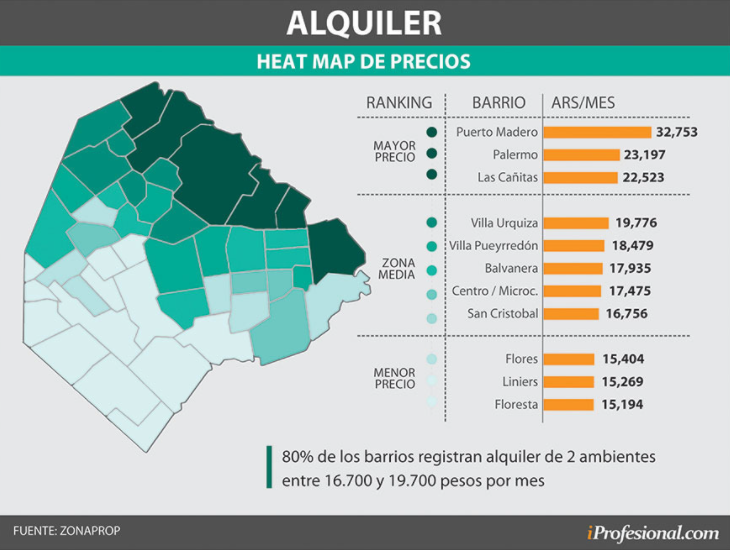

Vamos hacer una asociación entre lat/lon y barrio, usando el mapa de Barrios de Capital Federal que se puede bajar gratuitamente en "https://data.buenosaires.gob.ar/dataset/barrios".

In [ ]:
gdf = gpd.read_file('Ext/barrios_badata_wgs84.shp')
gdf = gdf.to_crs(epsg=3857)
ax = gdf.boundary.plot(figsize=(14,14), alpha=1.0, edgecolor='blue')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()

In [ ]:
gpd_barrios = gpd.read_file('Ext/barrios.geojson')
print(gpd_barrios.shape)
gpd_barrios.head(3)

In [ ]:
# Función que asocia un punto con long/lat a una barrio
def point_to_barrio(point):
    for i in range(0,len(gpd_barrios)):
        a=point.within(gpd_barrios.iloc[i,6])
        if a:
            return gpd_barrios.iloc[i,1]

punto_to_barrio=dentro_capitalfederal.geometry.apply(point_to_barrio)

In [ ]:
dentro_capitalfederal['barrios']=punto_to_barrio
dentro_capitalfederal.head()

Con este nuevo dataframe, podemos evaluar algunas propiedades interesantes. Primero, cuántos puntos por barrio tenemos, y entonces el precio por m2 medio para cada barrio, guardando la info en un dictionary.

In [ ]:
counting_points=dentro_capitalfederal.barrios.value_counts()
average_price_barrio=dentro_capitalfederal.groupby(by='barrios')['preciousd_m2covered'].mean()
dict_average_price_barrio=dict(average_price_barrio)

In [ ]:
filtrado_gpd=gpd_barrios[['BARRIO','geometry']].copy()
filtrado_gpd['preciousd_m2covered_media']=filtrado_gpd.BARRIO.replace(dict_average_price_barrio)
filtrado_gpd.preciousd_m2covered_media.describe()

In [ ]:
# Haciendo un plot espacial de los valores medios
ax = filtrado_gpd.plot(column='preciousd_m2covered_media',figsize=(14,14),alpha=1.0,
                       edgecolor='black',legend=True,cmap='BuGn',legend_kwds={'shrink': 0.75},vmax=4000);
ax.set_title('Percio en dólares por m2 en Capital Federal para cada barrio');
ax.set_xlabel('Longitud');
ax.set_ylabel('Latitud');

Este último gráfico es más cuantitativo, y muestra cómo cambia el precio por m2 medio dentro de Capital Federal. Este resultado confirma la importancia de tener una columna "barrio" para todos los puntos del dataframe, y no solamente la provincia y ciudad.

Por último, vamos a ver cómo cambia el precio total del imueble en función del número de ambientes, considerando los 9 barrios con más puntos que tenemos.

In [ ]:
fig, axs = plt.subplots(3, 3,figsize = (15,15))
# Selecionando los 9 barrios con más puntos
for x in range(0,9):
    i=x
    j=0
    if i > 5:
        j=2
        i=i-6
    if i > 2:
        j=1
        i=i-3
    mask=dentro_capitalfederal.barrios.isin([counting_points.index[x]])
    data_sh=dentro_capitalfederal.loc[mask]
    sns.barplot(data=data_sh,x='rooms',y='price_aprox_usd',ax=axs[i,j]);
    axs[i,j].set_xlim(left=-0.5,right=4.5),axs[i,j].set_ylim(bottom=0,top=500000);         
    axs[i,j].set_title(counting_points.index[x]);         

fig.tight_layout()
plt.show()

Podemos ver que, a pesar de haber un poco de fluctuación, hay una clara correlación entre el número de cuartos y el precio total del inmueble. Pero para cada barrio la correlación no es igual, y esto puede ser entendido por el hecho que el precio por m2 de cada barrio es muy diferente.

Se puede ver también que el desvío standard de los precios es más alto a medida que el número de piezas aumenta. De hecho, para propiedades con un valor de "rooms" de 6 o más, el desvío es tan grande que el patrón se pierde para algunos barrios. 

Hagamos un análisis similar enfocándonos ahora en Córdoba capital. El mapa fue descargado de la página de la Municipalidad de Córdoba, en "https://gobiernoabierto.cordoba.gob.ar/data/datos-abiertos/categoria/geografia-y-mapas/barrios-de-la-ciudad/118".

In [ ]:
gpd_barrios_cordoba = gpd.read_file('Ext/cordoba_Barrio.shp')
print(gpd_barrios_cordoba.shape)
gpd_barrios_cordoba.head(5)

In [ ]:
# Removiendo la primera línea, que está vacia y se llama "LALALALALA", o sea....
gpd_barrios_cordoba.drop(axis=0,index=gpd_barrios_cordoba.index[0],inplace=True)
# Convertendo para lat/lon
gpd_barrios_cordoba=gpd_barrios_cordoba.to_crs(epsg=4326)

In [ ]:
# Puntos dentro de Cordoba
cordoba = gpd_barrios_cordoba.geometry.unary_union
dentro_cordoba = geo_price[geo_price.geometry.within(cordoba)].copy()
dentro_cordoba.shape

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
gpd_barrios_cordoba.boundary.plot(ax=ax,color='black')
dentro_cordoba.plot(ax=ax,column='preciousd_m2covered',alpha=0.75,markersize=35,
               cmap='plasma',legend = True,legend_kwds={'shrink': 0.6},vmax=3000);
ax.set_title('Precios en dólares por m2 en Cordoba');
ax.set_xlabel('Longitud');
ax.set_ylabel('Latitud');

De nuevo, vemos una gran dependencia del precio por m2 con la ubiación. Pero el número de puntos que tenemos es mucho más limitado.

Vamos a contar cuántos puntos tenemos en cada barrio, y enfocar solamente en los barrios con por lo menos 20 puntos (que ya no es mucho).

In [ ]:
# Puntos por barrio
def point_to_barrio(point):
    for i in range(0,len(gpd_barrios_cordoba)):
        a=point.within(gpd_barrios_cordoba.iloc[i,4])
        if a:
            return gpd_barrios_cordoba.iloc[i,0]
punto_to_barrio=dentro_cordoba.geometry.apply(point_to_barrio)
dentro_cordoba['barrios']=punto_to_barrio
dentro_cordoba.head(2)

In [ ]:
counting_points_barrio=dentro_cordoba.groupby(by='barrios')['preciousd_m2covered'].count()
mask=counting_points_barrio>20
# Calculamos la média del precio total y del precio por m2
average_price_barrio=dentro_cordoba.groupby(by='barrios')['preciousd_m2covered'].mean()
total_price_barrio=dentro_cordoba.groupby(by='barrios')['price_aprox_usd'].mean()
average=average_price_barrio[mask]
total=total_price_barrio[mask]
# Juntamos en un Dataframe la info
pd.merge(average,total, on='barrios', how='left').sort_values(by='preciousd_m2covered',ascending=False)

Como pasó en Capital Federal, el precio del inmueble es muy dependiente de la ubicación. Es interesante también notar que en el barrio Nueva Córdoba los precios totales de los inmuebles no son los más altos, pero el precio por m2 sí. Esto indica que Nueva Córdoba es un barrio con alta concentración poblacional, donde el m2 vale mucho y los inmuebles son en general no tan grandes.

Infelizmente, el número de barrios del database proporcionado por la municipalidad de Córdoba es muy grande, más de 500, y tenemos en torno a 1200 puntos en nuestro dataframe original. 1200 puntos distribuidos en 500 barrios no nos permite hacer un análisis similar al que fue hecho para Buenos Aires, con precios proyectados en un mapa. Por lo tanto, cerramos acá el análisis de Córdoba.

Resumiendo, con Geopandas vemos ilustrativamente y cuantitativamente la dependencia entre el precio por m2 y la ubicación del inmueble, o sea, la provincia, ciudad y principalmente barrio en que se ubica. Concluimos que, sin la información del barrio, no hay cómo predicir con precisión el precio por m2 del inmueble. La ubicación es de hecho una característica imprescindible para la correcta  determinación del precio de un inmueble.

## Otras columnas que podrían agregar señal al dataset

Comenzamos creando una columna que contenga el valor 1 para aquellas propiedades que disponen de (o tienen acceso a) una piscina y 0 en otro caso. Para esto buscamos palabras clave como "piscina" o "pileta" en la descripción de la propiedad

In [ ]:
data['piscina'] = data['description'].str.contains('pisc|pilet')

In [ ]:
data['garage'] = data['description'].str.contains('coche|garage')

In [ ]:
data[(data['piscina'] == 1) & (data['property_type'] == 'house')]['price_aprox_usd'].mean()

In [ ]:
 data[(data['piscina'] == 0) & (data['property_type'] == 'house')]['price_aprox_usd'].mean()

Repetimos el mismo proceso anterior pero en este caso buscando las propiedades que disponen de (o tienen acceso a) una cochera

In [ ]:
data[(data['garage'] == 1) & (data['property_type'] == 'apartment') & 
     (data['place_name'] == 'Capital Federal')]['preciousd_m2covered'].mean()

In [ ]:
data[(data['garage'] == 0) & (data['property_type'] == 'apartment') & 
     (data['place_name'] == 'Capital Federal')]['preciousd_m2covered'].mean()

In [ ]:
data[(data['piscina'] == 1) & (data['property_type'] == 'house') & 
     (data['place_name'] == 'Capital Federal')]['price_aprox_usd'].mean()

In [ ]:
data[(data['piscina'] == 0) & (data['property_type'] == 'house') & 
     (data['place_name'] == 'Capital Federal')]['price_aprox_usd'].mean()

Observamos que no logramos datos útiles con respecto al valor por metro cuadrado pero sí vimos una relación apreciable con respecto al valor total de las propiedades.

## Análisis texto

### Preparación de columna texto

In [ ]:
# Concateno columnas de texto
data["texto"] = data["title"] + data["description"]

In [ ]:
# Dropeo columnas title y description
data.drop(columns = ["description", "title"], inplace = True)

In [ ]:
data["texto"].fillna("", inplace = True)

### Medias con palabras que implican un mayor valor

Hay palabras como *rentabilidad, invertir, proyecto, piscina, vista, cerca, exclusivo* o *esquina* que implican un mayor valor de una propiedad. También indican un mayor valor en el precio por metro cuadrado.
Para el caso de precio total, se incrementa un 11% las que contienen esas palabras, mientras que el valor por metro cuadrado lo hace un 12% contra el promedio general.
Otra manera de verlo es la comparación de precios totales entre los inmbuebles que tienen esas palabras en su texto, contra los que no. En ese caso notamos que que los inmuebles con palabras que denotan mayor valor son un 20% más caros que los que no, y su valor por metro cuadrado es un 22% superior.

Promedios de precio total de inmuebles con y sin las mencionadas palabras

In [ ]:
# Todos los inmuebles
data["price_aprox_usd"].mean()

In [ ]:
# Inmuebles con palabras de alto valor
data.loc[
         (data["texto"].str.
          contains("Renta|invertir|Invertir|renta|proyect|piscin|vist|cerca|esquin|exclusiv|Proyect|Piscin|Vist|Cerc|Esquin|Exclusiv"))
         ]["price_aprox_usd"].mean()

In [ ]:
# Inmuebles sin palabras de alto valor
data.loc[
         (data["texto"].str.
          contains("Renta|invertir|Invertir|renta|proyect|piscin|vist|cerca|esquin|exclusiv|Proyect|Piscin|Vist|Cerc|Esquin|Exclusiv") == False)
         ]["price_aprox_usd"].mean()

Promedios de precio por metro cuadrado construido de inmuebles con y sin las mencionadas palabras

In [ ]:
# Todos los inmuebles
data["preciousd_m2covered"].mean()

In [ ]:
# Inmuebles con palabras de alto valor
data.loc[
         (data["texto"].str.
          contains("Renta|invertir|Invertir|renta|proyect|piscin|vist|cerca|esquin|exclusiv|Proyect|Piscin|Vist|Cerc|Esquin|Exclusiv"))
         ]["preciousd_m2covered"].mean()

In [ ]:
# Inmuebles sin palabras de alto valor
data.loc[
         (data["texto"].str.
          contains("Renta|invertir|Invertir|renta|proyect|piscin|vist|cerca|esquin|exclusiv|Proyect|Piscin|Vist|Cerc|Esquin|Exclusiv") == False)
         ]["preciousd_m2covered"].mean()

### Columna indicio_mayor_valor

Sea que se compare con el valor total del inmueble o con el valor por metro cuadrado de superficie cubierta queda la luz que identificar esas propiedades en una feature (columna) podrían permitir a un modelo tener más precisión al momento de la predicción.

In [ ]:
def indicio_valor(x):
  lista_palabras_valor = ["renta", "invertir", "proyect", "vist", "cerca", "esquin", "exclusiv", "piscin"]
  for i in lista_palabras_valor:
    if i in x.lower():
      return 1
  
  return 0

In [ ]:
data["valor_texto"] = data["texto"].apply(indicio_valor)
data["valor_texto"] # Boolean, indicando presencia (1) o no (0)

# Conclusiones



*   Los datos proporcionados contienen información sobre inmuebles en venta en Argentina
*   Nuestro objetivo principal fue limpiar, completar, y analizar los datos, para intentar entender cómo es la variación en el precio por área de cada propiedad en función de las distintas características que posee
*   Debido a distintos datos faltantes, erróneos o confusos, creímos conveniente generar una columna *target* propia, con información sobre el precio en dólares dividido por el área cubierta de los inmuebles
*   Si bien la columna en la que se adiciona una descripción para el inmueble no da información directa, vimos que es posible extraer algunos datos que sirvieron para completar algunas columnas con faltantes
*   Observamos que el precio por metro cuadrado es extremadamente dependiente de la localización de la propiedad, siendo este un dato indispensable para un correcto análisis de mercado
*   Esta dependencia con la localización no solo se ve plasmada en el precio total de los inmuebles, sino que observamos que en las zonas más densamente pobladas, donde la actividad económica suele ser más importante, el precio por metro cuadrado es mucho más alto, haciendo que propiedades pequeñas posean un valor absoluto en dólares muy alto
*   Debido a la importancia del dato, sugerimos a la inmobiliaria Properati que la inclusión de la localización de las propiedades sea obligatoria en la carga de inmuebles a la base de datos, de preferencia seleccionando de opciones preexistentes.

